# TP2
Por Mariano Parada <BR>
DS-33<BR>
[Github](https://github.com/marianoparada/DataScience)

### Aclaraciones previas:
Este notebook complementa lo realizado en el TP1.<BR>
Para agilizar el proceso se tomó una muestra (si se quisiera ver el universo, setear la variable muestra de la primera celda en 100)

# Importamos los datos y los guardamos en un dataframe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

csv = pd.read_csv('properati.csv',encoding = 'utf-8')
data=pd.DataFrame(csv)

#Sacamos una muestra aleatoria. En muestra se debe poner el porcentaje a considerar.
#Dada la cantidad de registros estadísticamente la muestra nos dá métricas confiables por arriba del 10% 
muestra=15
experiment_size = int(len(data.index)*muestra/100)
completerandom_idx = data.sample(int(experiment_size),random_state = 42).index
data = data.loc[completerandom_idx,:]
data.shape

(21999, 19)

### Primer acercamiento
Recordando las variables ... 

In [2]:
data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
29115,2019-11-11,9999-12-31,2019-11-11,-34.556400,-58.449300,Argentina,Capital Federal,Belgrano,4.0,3.0,1.0,121.0,105.0,320000.0,USD,VENTA 4 AMB DEP Y COCHERA 121m2 BARRANCAS BELG...,Corredor Responsable: Pamela Suarez - CUCICBA ...,Departamento,Venta
50827,2019-12-06,2019-12-10,2019-12-06,-34.609362,-58.362203,Argentina,Capital Federal,Puerto Madero,3.0,2.0,4.0,176.0,176.0,1150000.0,USD,Vení a verlo !! VENTA 2 suites 1 coch,Renoir 2Espectacular departamento en la torre ...,Departamento,Venta
60166,2019-11-13,9999-12-31,2019-11-13,NaN,NaN,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,4.0,3.0,3.0,NaN,NaN,220000.0,USD,"Casa en Venta en San miguel, San miguel U$S 22...","Venta de Casa en San Miguel, San Miguel\nChale...",Casa,Venta
47744,2019-05-21,2019-07-10,2019-05-21,-34.563256,-58.462365,Argentina,Capital Federal,Belgrano,2.0,1.0,2.0,52.0,45.0,240000.0,USD,DEPARTAMENTO EN VENTA,Xintel (LAO-LAO-212) Venta de Departamento 2 A...,Departamento,Venta
125557,2019-11-22,9999-12-31,2019-11-22,-34.644296,-58.507740,Argentina,Capital Federal,Liniers,2.0,1.0,1.0,NaN,NaN,140000.0,USD,Departamento dos ambientes Villa luro,Venta de Departamento 2 AMBIENTES en Villa Lur...,Departamento,Venta


### Reemplazamos los nombres de columna que tienen caracteres con tilde
Esto nos permitirá reducir errores en nuestros algoritmos de ML ya que algunos no permiten ASCII extendidos como nombres de columna.

In [3]:
data['l3'] = data['l3'].str.replace(u"á", "a")
data['l3'] = data['l3'].str.replace(u"é", "e")
data['l3'] = data['l3'].str.replace(u"í", "i")
data['l3'] = data['l3'].str.replace(u"ó", "o")
data['l3'] = data['l3'].str.replace(u"ú", "u")
data['l3'] = data['l3'].str.replace(u"ñ", "n")

### Empezaremos verificando los elementos faltantes:

In [4]:
data.isnull().sum()

start_date            0
end_date              0
created_on            0
lat                1515
lon                1520
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms           923
surface_total      3028
surface_covered    3172
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

### Resultado:
las columnas lat, lon, bathrooms, surface_total y surface_covered tienen valores faltantes

### Crearemos una nueva característica precio_m2
Sacaremos el promedio del precio en cada barrio para luego dividirlo por los m2 de cada propiedad. De esta forma estaremos agregando valor a nuestro modelo ya que consolidaremos varios aspectos (superficie, precio, ubicación, características de la propiedad) en 1 sola característica pero apoyado en datos estadísticos , es decir, sin pasarle la variable de respuesta.

In [5]:
#data['price_m2']=data.groupby(['l3','property_type']).price.transform('mean').astype(np.int)


In [6]:
#data['price_mean'] = data.groupby(['property_type' , 'l3'])['price'].transform('mean').astype(np.int)

# Vamos a analizar algunos features para verificar si serán o no de utilidad: 
### a) lat y lon: Contaremos las instancias de cada valor de lat y lon para identificar si son valores reales o referenciales.

In [7]:
conteo_puntos = data.groupby(['lat', 'lon']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

lat         lon       
-34.425087  -58.579659    81
-34.597256  -58.445498    44
-34.596762  -58.421589    35
-34.578066  -58.426532    32
-34.579326  -58.455819    31
-34.602133  -58.466831    28
-34.589767  -58.420728    27
-34.587383  -58.397276    27
-34.588007  -58.420122    27
-34.542750  -58.460145    26
dtype: int64

Veamos cuanto inciden Lat y Lon en el precio analizando los coeficientes por correlación de Pearson:

In [8]:
corr = data[['lat', 'lon', 'price']]
corr = corr.corr()
corr

,lat,lon,price
lat,1.000000,-0.65943,0.078309
lon,-0.659430,1.00000,0.026450
price,0.078309,0.02645,1.000000


Cantidad de publicaciones por Barrio (Top 5)

In [9]:
conteo_puntos = data.groupby(['l3']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(5)

l3
Palermo      2008
Tigre        1341
Almagro      1116
Caballito    1041
Belgrano     1014
dtype: int64

Como podemos apreciar, los valores son referenciales ya que estan repetidos y no inciden significativamente en el precio (0.12 y 0.044). Podríamos inferir que hacen referencia a un punto dentro de ese barrio, podría ser una manzana o un conjunto de manzanas.

### b) Verificamos en las variables categóricas currency y operation_type cuantos tipos hay en cada una:

In [10]:
conteo_puntos = data.groupby(['currency']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

currency
USD    21999
dtype: int64

In [11]:
conteo_puntos = data.groupby(['operation_type']).size()
conteo_puntos[conteo_puntos > 1].sort_values(ascending=False).head(10)

operation_type
Venta    21999
dtype: int64

Ambas variables adoptan un solo valor, por lo que no serán convertidas ni incorporadas al modelo.<br>

### c) Habitaciones vs Ambientes: Analizamos la correlación entre las variables rooms y bedrooms utilizando las correlaciones de Pearson y Spearman de la librería SciPy

In [12]:
from scipy.stats import pearsonr
corr, _ = pearsonr(data.rooms, data.bedrooms)
print('Correlación de Pearsons: %.3f' % corr)

Correlación de Pearsons: 0.849


In [13]:
from scipy.stats import spearmanr
corr, _ = spearmanr(data.rooms, data.bedrooms)
print('Correlación de Spearmans : %.3f' % corr)

Correlación de Spearmans : 0.920


Como vemos estan correlacionadas en promedio en más del 90%, lo cual puede sesgar al modelo ya que casi estaría duplicando el peso para una característica.

# Resultado del análisis de features:
Al no ser lat y lon un valor de geolocalización preciso, y tener muchos datos faltantes vamos a eliminar las columnas (luego crearemos un nuevo feature que pueda representar la relación entre el precio y la ubicación) <br>
Revisando la documentación las fechas no representan el tiempo que una propiedad fue publicada y vendida, lo cual hubiera sido significativamente útil ya que podría haber creado una nueva característica para identificar una zona como "tendencia" que incida en un plus en el precio de venta de las propiedades cercanas.<br>
Al no quedar claro ni los valores, ni el criterio utilizado para cada columna de fechas, start_date, end_date y created_on serán eliminadas.<br>
Dentro de los features de ubicación, nos quedaremos con L3 ya que hace referencia al barrio, el cual podría ser un feature interesante para verificar si incide en el precio, por lo que borraremos L1 y L2.<br>
También como hemos corroborado anteriormente eliminaremos los cuartos (bedrooms) por estar altamente correlacionado con cuartos (rooms).<br>
Por último eliminaremos los features: description y title.

## Eliminamos entonces: 'lat','lon','start_date','end_date','created_on','l1','l2','currency','operation_type' y 'bedrooms'.

In [14]:
data = data.drop(columns=['lat','lon','start_date','end_date','created_on','l1','l2','currency','operation_type','bedrooms','description','title'],axis=1)

# Analisis de valores faltantes

Definimos la función missing_values_table para mostrar mas intuitivamente las columnas y el porcentaje de valores faltantes:


In [15]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valores faltantes', 1 : '% del Total'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% del Total', ascending=False).round(1)
        
        # Print some summary information
        print ("El DataFrame tiene  " + str(df.shape[1]) + " columns.\n"      
            "Hay " + str(mis_val_table_ren_columns.shape[0]) +
              " columnas con valores faltantes")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [16]:
df_missing= missing_values_table(data)
df_missing

El DataFrame tiene  7 columns.
Hay 3 columnas con valores faltantes


,Valores faltantes,% del Total
surface_covered,3172,14.4
surface_total,3028,13.8
bathrooms,923,4.2


Utilizamos la función missing_values_table para observar las columnas del dataset que tiene datos faltantes. La función también calcula el porcentaje de valores faltantes respecto al total lo cual nos permitirá decidir respecto de como abordar los faltantes para cada feature.

Las variables con valores faltantes son "surface_covered", "surface_total" y "bathrooms"

## Visualizando valores faltantes en una muestra con Missingno:

Para visualizar gráficamente los datos faltantes utilizaremos la librería missingno, lo cual nos dará una idea de si los datos faltantes corresponden a un error, un sesgo, o son aleatorios.
Veamos en particular "surface_covered", "surface_total", "lon", "lat" y "bathrooms" :


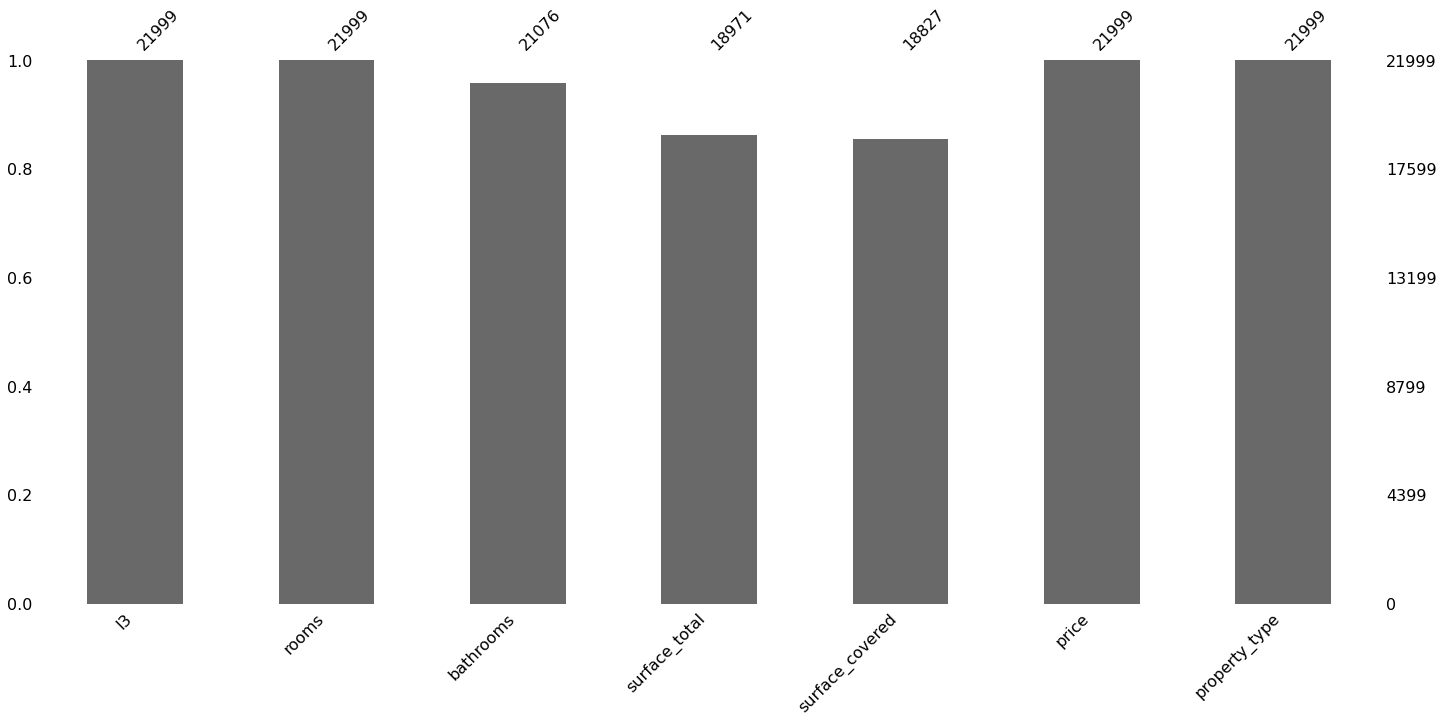

In [17]:
import missingno as msno
msno.bar(data)

### Visualizando la ubicación de los datos faltantes

>Con la función msno.matrix podemos encontrar patrones sobre los datos faltantes con la finalidad de entender su origen.


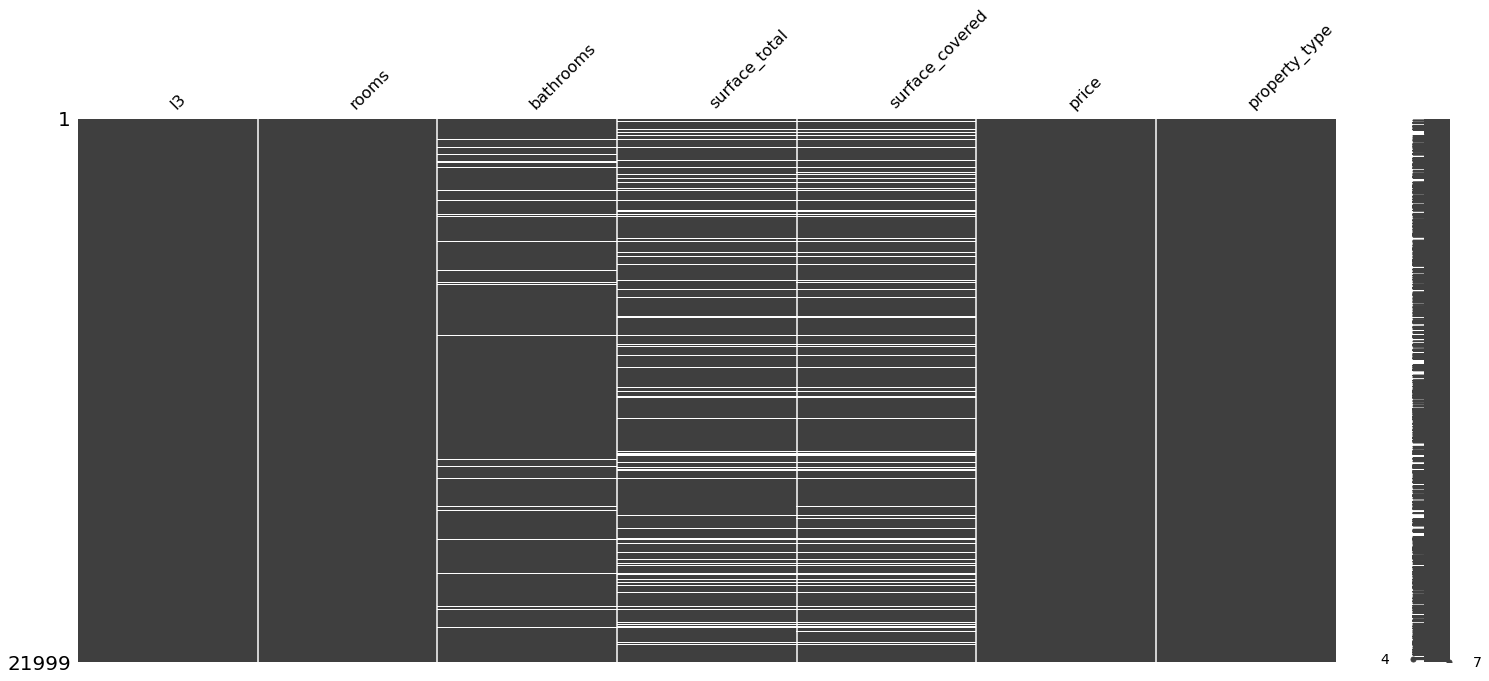

In [18]:
msno.matrix(data)

Vamos a analizar los mismos datos pero ordenando los valores por l3, para identificar si los valores faltantes tienen que ver con esta variable:(l3)

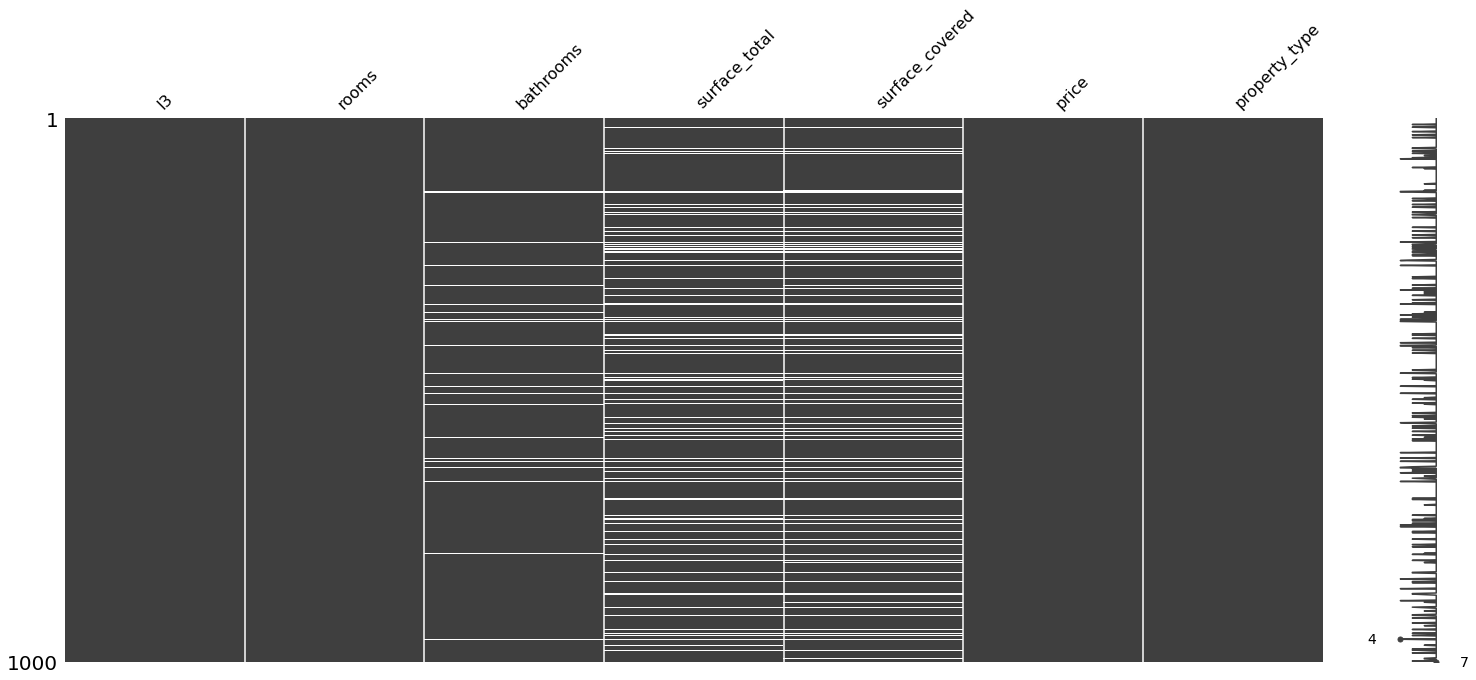

In [19]:
sorted = data.sort_values('l3', ascending = False)
msno.matrix(sorted.sample(1000))

Como no corresponden al mismo barrio tomaremos al valor como un faltante aleatorio. Aunque parecería que existe relación en valores faltantes de surface_covered y surface_total.<BR>
A continuación y como primera medida vamos a identificar : <BR>
1. Cuantos valores faltantes hay en cada uno.<BR>
2. Cuando falte solo uno, asignarle al otro el mismo valor.

# Imputación de valores faltantes
Aquí analizaremos la mejor alternativa para las columnas con valores faltantes. Recordemos que features tienen valores faltantes:

In [20]:
missing_values_table(data)

El DataFrame tiene  7 columns.
Hay 3 columnas con valores faltantes


,Valores faltantes,% del Total
surface_covered,3172,14.4
surface_total,3028,13.8
bathrooms,923,4.2


Primero imputaremos el valor de surface_covered a aquellas propiedades que no tengan un valor de surface_total:

In [21]:
missing_values_table(data)

El DataFrame tiene  7 columns.
Hay 3 columnas con valores faltantes


,Valores faltantes,% del Total
surface_covered,3172,14.4
surface_total,3028,13.8
bathrooms,923,4.2


In [22]:
data.surface_total=data.surface_total.fillna(data.surface_covered)
data.surface_covered=data.surface_covered.fillna(data.surface_total)

### Hemos imputado mas de 2100 propiedades:<br>
1. 515 propiedades:  valores surface.covered > surface.total<br>
2. 1602 propiedades: valores surface.covered > surface.total<br>

Veamos cuantas instancias quedaron con valores faltantes en superficie luego de este procedimiento:

In [23]:
missing_values_table(data)

El DataFrame tiene  7 columns.
Hay 3 columnas con valores faltantes


,Valores faltantes,% del Total
surface_total,2950,13.4
surface_covered,2950,13.4
bathrooms,923,4.2


Por último, en el caso de que no tengamos ningún valor para surface_covered ni surface_total y bathrooms vamos a utilizar la función KNN imputer de la librería SKLearn.
Para realizar eficientemente el encoding y scaling separaremos nuestro dataset en 2:<BR>
>  1. data_num: features numéricos -> ['rooms', 'bathrooms', 'surface_total','surface_covered','price']]<BR>
>  2. data_cat: features categóricos -> ['l3', 'property_type']]<BR>

Como Knn no funciona con variables categóricas pero primero debo partir el dataset. Esto también será de utilidad para realizar el encoding y scaling mas adelante, ya que no funciona con variables categóricas:

In [24]:
data_num = data[['rooms', 'bathrooms', 'surface_total','surface_covered','price']]
data_cat = data[['l3', 'property_type']]

### Imputación de surface_covered, surface_total y bathrooms utilizando KNNImputer
Le pasamos como dataset data_num ya que KNN solo funciona con valores numéricos. Se utilizarán 3 vecinos cercanos ya que un número mas grande aumenta significativamente el tiempo de ejecución. Finalmente se agrega la sentencia %%time para visualizar el tiempo de ejecución:

In [25]:
%%time
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(data_num)
data_filled = imputer.transform(data_num)

Wall time: 7.44 s


### Rearmamos el DataFrame y cambiamos su nombre para conservar ambos:
Luego visualizamos que no quedan datos faltantes:

In [26]:
#reconvertimos el array en DataFrame y verificamos que no hayan quedado valores nulos
data_filled=pd.DataFrame(data_filled,columns=data_num.columns)

In [27]:
data_filled.isnull().sum()

rooms              0
bathrooms          0
surface_total      0
surface_covered    0
price              0
dtype: int64

# ;)

In [28]:
data_filled.head()

,rooms,bathrooms,surface_total,surface_covered,price
0,4.0,1.0,121.0,105.0,320000.0
1,3.0,4.0,176.0,176.0,1150000.0
2,4.0,3.0,387.0,106.0,220000.0
3,2.0,2.0,52.0,45.0,240000.0
4,2.0,1.0,54.2,46.8,140000.0


### Analisis y encoding de variables categóricas (property_type)  y  el barrio (l3)
Como nuestro modelo solo entenderá números, hay dos variables categóricas que debemos codificar numéricamente.
<BR>
Analizando ambas variables tanto l3 como el tipo de propiedad NO indican orden, por lo que son nominales.<BR>
En este sentido si utilizaramos LabelEncoder de SkLearn cometeríamos un error ya que le asignaría a cada tipo números consecutivos que en el caso de l3 tendríamos una variable número 1 otra número 68, por lo que esta diferencia sesgaría mi modelo infiriendo que al barrio 68 debería asignarle mayor valor que al 1.<BR>
Para que esto no suceda utilizaremos la librería get_dummies de pandas, para pasar cada valor de cada variable categórica de nuestro dataset data_cat a nuevas columnas y representarlo con un valor dummie (1) o (0). 

In [29]:
# Guardamos el barrio por si lo necesitáramos más adelante:
data_cat['barrio'] = data_cat['l3']
data_cat['tipo'] = data_cat['property_type']
# Aplicamos get_dummies:
data_dummies = pd.get_dummies (data_cat, columns = ['l3','property_type'])

In [30]:
data_dummies.head()

,barrio,tipo,l3_Abasto,l3_Agronomia,l3_Almagro,l3_Almirante Brown,l3_Avellaneda,l3_Balvanera,l3_Barracas,l3_Barrio Norte,...,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_PH
29115,Belgrano,Departamento,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
50827,Puerto Madero,Departamento,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
60166,San Miguel,Casa,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
47744,Belgrano,Departamento,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
125557,Liniers,Departamento,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Guardamos en una variable cuantas instancias tenemos para saber al final cuantos outliers se eliminaron...

In [31]:
entrada = len(data_filled.index)

# Gestión de valores atípicos (outliers)
Analizaremos valores atípicos que puedan sesgar el modelo y bajar la performance de mi predicción.
<BR>
Trabajaremos con la fórmula de intercuartiles para establecer valores mínimos y máximos en el dataset data_num:

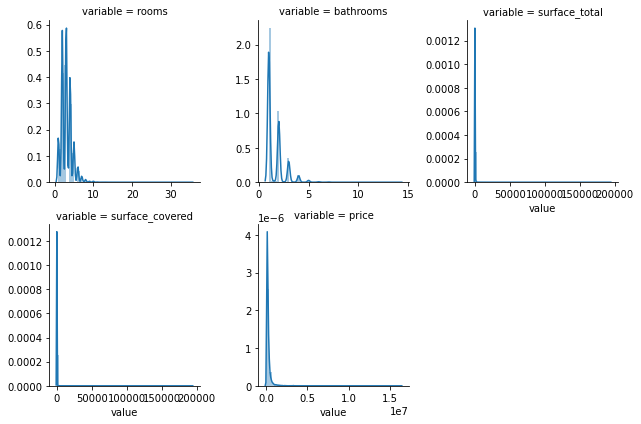

In [32]:
# Credits to Dominik Gawlik in Kaggle: https://www.kaggle.com/dgawlik/house-prices-eda
features = [f for f in data_filled.columns if data_filled.dtypes[f] != 'object']
melt = pd.melt(data_filled, value_vars = features)
facetgrid = sns.FacetGrid(melt, col = "variable",  col_wrap = 3, sharex = False, sharey = False)
distribucion = facetgrid.map(sns.distplot, "value")

Como vemos nuestros datos no estan bien distribuidos. Al realizar ingeniería de características para un modelo de regresión, intentaremos realizar transformaciones a nuestros datos para acotarlos dentro de una distribución de Gauss (normal) lo cual mejorará significativamente las métricas de nuestros algoritmos ya que de no hacerlo, como dice el dicho: "garbage in, garbage out".

### Vamos a evaluar la asimetría y curtosis con las funciones Skew y Kurt:

In [33]:
#skewness and kurtosis
print("Skewness: " + str(data_filled['price'].skew()))
print("Kurtosis: " + str(data_filled['price'].kurt()))

Skewness: 12.005513031160074
Kurtosis: 406.25914293703903


### Skew:
Si en una distribución normal skew() debería ser 0, un valor positivo significa que la cola en el lado derecho de la distribución es más larga y más gruesa.En asimetría positiva, la media y la mediana serán mayores que la moda similar a este conjunto de datos.
Esto nos sugiere que hay publicadas casas a un precio inferior al promedio.

### Kurt
Con Kurt medimos la curtosis, es decir cuanto inciden o representan las colas de nuestra ditribución (valores atípicos). Con un valor positivo se esperará un centro más apuntado y con colas más gruesas que la normal. Con un valor negativo se esperará un centro menos apuntado y con colas menos gruesas que la normal. El valor que debemos buscar es lo más cercano a 0 posible para una distribución normal.
Debemos corregirlo ya que sino nuestro modelo quedará sesgado.

### Outliers: utilizaremos la fómula de intercuartiles para depurar valores mínimos y máximos
Primero, unimos el DataFrame

In [34]:
data_dummies.reset_index(inplace=True, drop=True)
data_filled.reset_index(inplace=True, drop=True)
data_filled = pd.concat([data_filled, data_dummies], axis=1)

In [35]:
columns = ['rooms','bathrooms','surface_total','surface_covered','price']
for i in columns:
    q1 = data_filled[i].quantile(0.25)
    q3 = data_filled[i].quantile(0.75)
    iqr = q3 - q1
    data_filled = data_filled[~((data_filled[i] < (q1 - 1.5 * iqr)) | (data_filled[i] > (q3 + 1.5 * iqr)))]

In [36]:
salida = len(data_filled.index)
print(entrada-salida)

4775


### Cantidad de registros eliminados: 32.044
Veamos entonces si mejoró la distribución y los valores de Skew y Kurt:

### Veamos como quedaron las distribuciones:

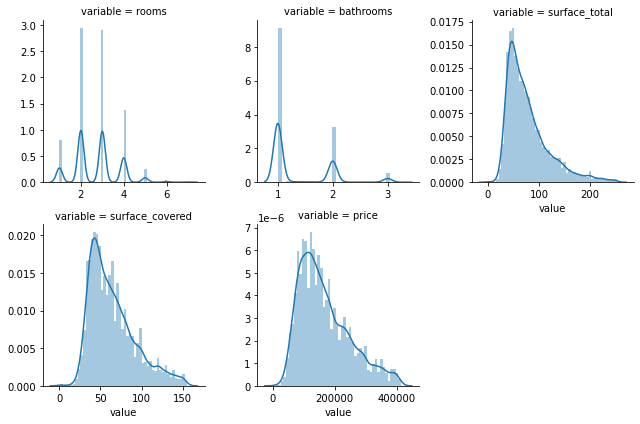

In [37]:
features = ['rooms','bathrooms','surface_total','surface_covered','price']
melt = pd.melt(data_filled, value_vars = features)
facetgrid = sns.FacetGrid(melt, col = "variable",  col_wrap = 3, sharex = False, sharey = False)
distribucion = facetgrid.map(sns.distplot, "value")

In [38]:
print("Skewness: " + str(data_filled['price'].skew()))
print("Kurtosis: " + str(data_filled['price'].kurt()))

Skewness: 0.8593640507738701
Kurtosis: 0.12916781642295838


Como se puede apreciar, nuestra variable de respuesta mejoró significativamente los valores de asimetría y curtosis luego de haber eliminado los outliers con el método intercuartil.<BR>
Skewness: pasó de 19 -> 0.86 <BR>
Kurtosis: pasó de 1210 -> 0.15    

![ChessUrl](https://media3.giphy.com/media/VDM2XFgp0M2lg1daUH/giphy.gif "Party")

### Reducción de dimensionalidad: consolidaremos 3 features en 1:
Como ya vimos en el TP1, hay una disperción de precios importante, por lo que nuestro modelo podría sub-ajustar (underfitting) la variable de respuesta ante propiedades de similares características ubicadas en diferentes barrios (l3).<br>
Para consolidar los 3 features en uno, sacaremos el precio del mt2 para cada propiedad por cada barrio (l3) como ya explicamos anteriormente. Como ya tenemos los barrios como columnas Dummies este calculo fue trasladado a la segunda celda.

In [39]:
data_filled.head()

,rooms,bathrooms,surface_total,surface_covered,price,barrio,tipo,l3_Abasto,l3_Agronomia,l3_Almagro,...,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_PH
0,4.0,1.0,121.0,105.0,320000.0,Belgrano,Departamento,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2.0,2.0,52.0,45.0,240000.0,Belgrano,Departamento,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,2.0,1.0,54.2,46.8,140000.0,Liniers,Departamento,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,3.0,1.0,195.0,67.0,80000.0,La Plata,PH,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,3.0,1.0,63.0,55.0,165000.0,Palermo,Departamento,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [40]:
data_filled['price_m2'] = data_filled.groupby(['tipo' , 'barrio'])['price'].transform('mean').astype(np.int)
data_filled['price_m2'] = data_filled['price_m2']/data_filled['surface_covered']

Ahora vamos a crear un feature llamado "surface_uncovered" para representar a la superficie descubierta ya que me parece importante que las propiedades puedan tener ese diferencial.

In [41]:
data_filled['surface_uncovered'] = data_filled['surface_total']-data_filled['surface_covered']

Como separamos la superficie en cubierta y descubierta, eliminaremos surface_total para no incorporar dos veces el mismo dato ya que duplicaríamos el peso de esa variable.

In [42]:
data_filled = data_filled.drop("surface_total", axis=1)
data_filled = data_filled.drop("barrio", axis=1)
data_filled = data_filled.drop("tipo", axis=1)

In [43]:
data_filled.price_m2.dtypes

dtype('float64')

### Escalado de features numéricos
Vamos a utilizar la función StandardScaler() de SKLearn para escalar nuestros datos, pero antes debemos separar la variable de respuesta para que no se vea afectada:

In [44]:
data_num = data_filled.filter(['rooms','bathrooms','surface_covered','surface_uncovered','price_m2'], axis=1)

In [45]:
data_dummies = data_filled.drop(columns=['rooms','bathrooms','surface_covered','surface_uncovered','price_m2'])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)
data_scaled = pd.DataFrame(data_scaled,columns=data_num.columns)

### Luego de segmentar nuestro dataset para escalar las características numéricas, rearmamos el dataset:
consolidamos en [data] -> [data_scaled] & [data_dummies]

In [47]:
data_dummies.reset_index(inplace=True, drop=True)
data_scaled.reset_index(inplace=True, drop=True)
data = pd.concat([data_scaled, data_dummies], axis=1)

# Optimizando nuestro tiempo ...
Debido al tiempo que insumimos en imputar valores faltantes, encodear y escalar haremos una bajada a csv para ahorrar tiempo de aquí en más.

In [48]:
#data= data.to_csv('properati2.csv',index=False)

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [50]:
#data = pd.read_csv('properati2.csv')

### Funciones para calcular las métricas:

In [51]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# Comparación del resultado del TP1 vs el TP2 teniendo en cuenta la ingeniería de features realizadas y la utilización de algoritmos mas complejos.
Como punto de partida tenemos que el modelo que mejor funcionó en el TP1 fue el de vecinos cercanos tomando más de 12 vecinos con un RMSE de U$D 152.699. Veamos si mejoró con la ingeniería de features realizada:

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
X = data.drop("price", axis=1)
y = data.price

In [53]:
X.head()

,rooms,bathrooms,surface_covered,surface_uncovered,price_m2,l3_Abasto,l3_Agronomia,l3_Almagro,l3_Almirante Brown,l3_Avellaneda,...,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,property_type_Depósito,property_type_Local comercial,property_type_Lote,property_type_Oficina,property_type_Otro,property_type_PH
0,1.302753,-0.617280,1.458332,0.119473,-0.213029,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.697569,1.177337,-0.700611,-0.271337,0.322960,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.697569,-0.617280,-0.635842,-0.253968,-0.007307,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.302592,-0.617280,0.091002,4.982889,-0.360323,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.302592,-0.617280,-0.340787,-0.227914,0.113717,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Separamos nuestros datos para entrenamiento y testeo utilizando train_test_split de SkLearn:

In [54]:
#Separacion y entrenamiento del modelo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

### Vecinos cercanos:

In [55]:
from sklearn.neighbors import KNeighborsRegressor
clf_knn = KNeighborsRegressor(n_neighbors=13)
clf_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=13)

In [56]:
%%time
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_train_pred_knn = clf_knn.predict(X_train)
y_test_pred_knn = clf_knn.predict(X_test)

Wall time: 10.5 s


### Creamos un panda donde guardaremos los resultados de las métricas
Usaremos las funciones creadas anteriormente "evaluate" y "print_evaluate" y "crossval"

In [57]:
%%time
resultados = pd.DataFrame(data=[["TP1 Knn", "0.00","0.00","152699.00","0.00","0.00"]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados2 = pd.DataFrame(data=[["Knn", *evaluate(y_test, y_test_pred_knn) , cross_val(KNeighborsRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados = resultados.append(resultados2, ignore_index=True)
print('Métricas con el set de pruebas:\n_____________________________________')
print_evaluate(y_test, y_test_pred_knn)
print('====================================')
print('Métricas con el set de entrenamiento:\n_____________________________________')
print_evaluate(y_train, y_train_pred_knn)

Métricas con el set de pruebas:
_____________________________________
MAE: 33518.012897201326
MSE: 2155378222.8712664
RMSE: 46426.05112295538
R2 Square 0.6841837513832173
Métricas con el set de entrenamiento:
_____________________________________
MAE: 29015.8013264898
MSE: 1672270492.2871459
RMSE: 40893.40401931766
R2 Square 0.7453460468643037
Wall time: 12.5 s


Text(0, 0.5, 'y_pred (test)')

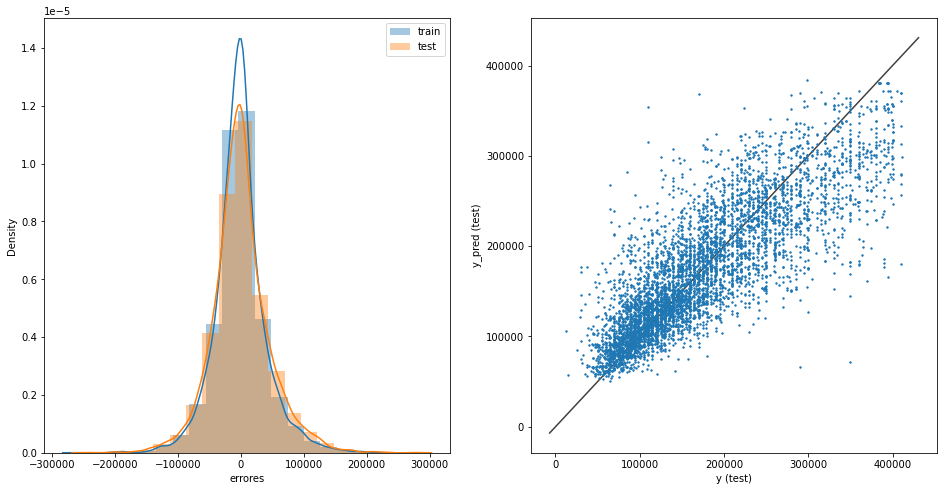

In [58]:
plt.figure(figsize = (16,8))
plt.title("Vecinos cercanos") 
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_knn, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_knn, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_knn, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

# Parte B: 
Random Forest y XGBoost. Validación cruzada.
Optimización de hiperparámetros mediante Validación Cruzada y Random Search 
Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A. ¿Cuál elegirías? Justifica.

In [59]:
#!pip install xgboost

In [60]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

### Random Forest y validación cruzada con random Search y Cross Validation:
Comenzaremos probando el algoritmo Random Forest probando distintos hiperparámetros, como ser cantidad de árboles, cantidad de features óptimos a tener en cuenta, máxima profundidad del árbol, mínimo número de muestras requeridas para separar un nodo y mínimo número de muestras en cada hoja del árbol.
Una vez que hallamos encontrado los hiperparámetros los guardaremos en una variable ya que el algoritmo tardó más de 12 horas para finalizar.

In [61]:
%%time

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5]
#min_samples_leaf = [1, 2]
#bootstrap = [True, False]# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=21, n_jobs = -1)# Fit the random search model
#rf_random.fit(X_train, y_train)

Wall time: 0 ns


A continuación visualizaremos que hiperparámetros funcionaron mejor para nuestro algoritmo con la función best_params:

In [62]:
#mejores_parametros = rf_random.best_params_
#mejores_parametros dió {'n_estimators': 977,  'min_samples_split': 2,
# 'min_samples_leaf': 1,  'max_features': 'sqrt',  'max_depth': 50,  'bootstrap': True}

Guardamos los parámetros en un diccionario para no volver a correr la optimización ya que tardó más de 12 horas:

In [63]:
mejores_parametros = {
    'n_estimators' : 977,
    'min_samples_split' : 2,
    'min_samples_leaf' : 1,
    'max_features' : 'sqrt',
    'max_depth' : 50,
    'bootstrap' : 'True'
}

In [64]:
%%time
RFR = RandomForestRegressor(**mejores_parametros)
RFR.fit(X_train, y_train)

Wall time: 31.3 s


RandomForestRegressor(bootstrap='True', max_depth=50, max_features='sqrt',
                      n_estimators=977)

Vamos a instanciar nuestro algoritmo invocando a los mejores hiperparámetros encontrados y luego haremos la predicción con nuestro set de entrenamiento y testeo.

In [65]:
%%time
y_train_pred_RFR = RFR.predict(X_train)
y_test_pred_RFR = RFR.predict(X_test)

Wall time: 6.11 s


### Calculamos y guardamos las métricas para RandomForest: 

In [66]:
%%time
print('Métricas con el set de pruebas:\n_____________________________________')
print_evaluate(y_test, y_test_pred_RFR)
print('====================================')
print('Métricas con el set de entrenamiento:\n_____________________________________')
print_evaluate(y_train, y_train_pred_RFR)
resultados2 = pd.DataFrame(data=[["RandomForest", *evaluate(y_test, y_test_pred_RFR) , cross_val(RandomForestRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados = resultados.append(resultados2, ignore_index=True)

Métricas con el set de pruebas:
_____________________________________
MAE: 26974.836776539138
MSE: 1569055710.3159115
RMSE: 39611.30785919485
R2 Square 0.7700945091471729
Métricas con el set de entrenamiento:
_____________________________________
MAE: 10862.791199401097
MSE: 261231199.66181517
RMSE: 16162.648287388276
R2 Square 0.960219618785907
Wall time: 2min 1s


Text(0, 0.5, 'y_pred (test)')

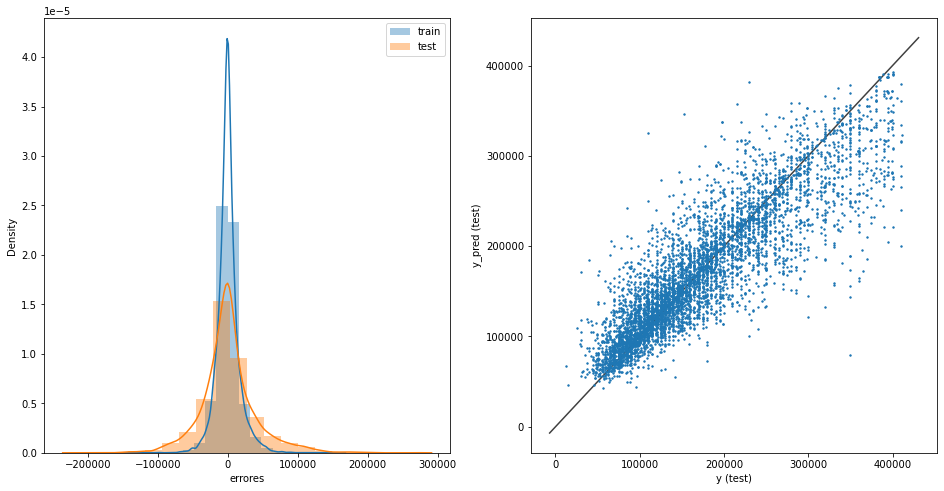

In [67]:
plt.figure(figsize = (16,8))
plt.title("Random Forest: Comparamos los datos de entrenamiento, los de testeo y como se ajustan al modelo") 
plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_RFR, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_RFR, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_RFR, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

# XGBoost - GbTree

In [68]:
%%time
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
xgbregressor = XGBRegressor(booster='gbtree', n_estimators=977,max_depth=50)
xgbregressor.fit(X_train, y_train)
# Intentaremos utilizar algnos de los hiperparámetros optimizados para Random Forest ya que entiendo que funcionará también para otro esquema de árboles
#{'n_estimators': 422,'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 34, 'bootstrap': True}

Wall time: 1min 15s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=977, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
# Predicting the Test set results
y_train_pred_XGB = xgbregressor.predict(X_train)
y_test_pred_XGB = xgbregressor.predict(X_test)

In [70]:
resultados2 = pd.DataFrame(data=[["XGBoost-Tree", *evaluate(y_test, y_test_pred_XGB) , cross_val(XGBRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados = resultados.append(resultados2, ignore_index=True)

Text(0, 0.5, 'y_pred (test)')

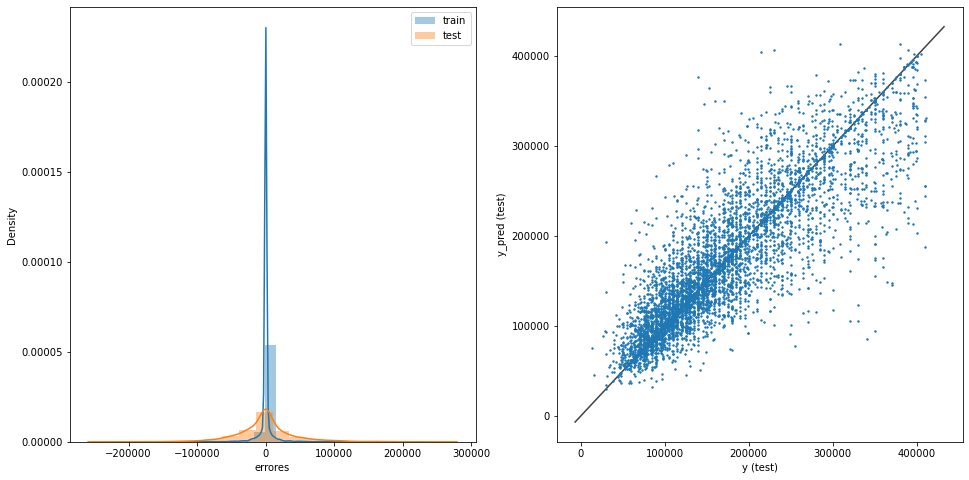

In [71]:
plt.figure(figsize = (16,8))
plt.title('XGBoost -Regressor- :Comparamos los datos de entrenamiento, los de testeo y como se ajustan al modelo') 

plt.subplot(1,2,1)

sns.distplot(y_train - y_train_pred_XGB, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_XGB, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()

ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_XGB, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

# XGBoost - GbLinear

In [72]:
%%time
# Fitting XGBoost to the Training set
from xgboost import XGBRegressor
xgbregressor = XGBRegressor(booster='gblinear', n_estimators=977,max_depth=50)
xgbregressor.fit(X_train, y_train)

[12:42:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 1.81 s


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=None, max_depth=50,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=977, n_jobs=0, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [73]:
y_train_pred_XGB = xgbregressor.predict(X_train)
y_test_pred_XGB = xgbregressor.predict(X_test)

In [74]:
resultados2 = pd.DataFrame(data=[["XGBoost-Linear", *evaluate(y_test, y_test_pred_XGB) , cross_val(XGBRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados = resultados.append(resultados2, ignore_index=True)
resultados

,Model,MAE,MSE,RMSE,R2,CV
0,TP1 Knn,0.00,0.00,152699.00,0.00,0.00
1,Knn,33518,2.15538e+09,46426.1,0.684184,0.716627
2,RandomForest,26974.8,1.56906e+09,39611.3,0.770095,0.774809
3,XGBoost-Tree,28136.3,1.84351e+09,42936.1,0.729881,0.766614
4,XGBoost-Linear,35072.6,2.22665e+09,47187.4,0.673741,0.766614


# Desafio: Probemos con el algoritmo del que todos hablan: LightGBM

In [75]:
#pip install lightgbm
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

Como lightGBM no soporta caracteres no ASCII en sus columnas, implementamos esta función para que reemplace los caracteres no ascii que pueda haber.


In [76]:
%%time
import re
df = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X = df.drop("price", axis=1)
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)

Wall time: 21 ms


In [77]:
%%time
# Finalize a set of parameters
hyper_params = {
    'task': 'train',
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 50,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 1000,
    "n_estimators": 977,
    'silent': 'True',
}

# Training
print('Entrenamos LightGBM con nuestros hiperparámetros ...')
gbm = lgb.LGBMRegressor(**hyper_params)

# Fit model
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l2',
        early_stopping_rounds=1000)

Entrenamos LightGBM con nuestros hiperparámetros ...
[1]	valid_0's l2: 2.74282e+09	valid_0's auc: 1
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l2: 2.12253e+09	valid_0's auc: 1
[3]	valid_0's l2: 2.0584e+09	valid_0's auc: 1
[4]	valid_0's l2: 2.02891e+09	valid_0's auc: 1
[5]	valid_0's l2: 2.03684e+09	valid_0's auc: 1
[6]	valid_0's l2: 2.04061e+09	valid_0's auc: 1
[7]	valid_0's l2: 2.08082e+09	valid_0's auc: 1
[8]	valid_0's l2: 2.10358e+09	valid_0's auc: 1
[9]	valid_0's l2: 2.13327e+09	valid_0's auc: 1
[10]	valid_0's l2: 2.10199e+09	valid_0's auc: 1
[11]	valid_0's l2: 2.08847e+09	valid_0's auc: 1
[12]	valid_0's l2: 2.08889e+09	valid_0's auc: 1
[13]	valid_0's l2: 2.10264e+09	valid_0's auc: 1
[14]	valid_0's l2: 2.06815e+09	valid_0's auc: 1
[15]	valid_0's l2: 2.04278e+09	valid_0's auc: 1
[16]	valid_0's l2: 2.05463e+09	valid_0's auc: 1
[17]	valid_0's l2: 2.03471e+09	valid_0's auc: 1
[18]	valid_0's l2: 2.02161e+09	valid_0's auc: 1
[19]	valid_0's l2: 2.01038e+09

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, boosting_type='rf',
              feature_fraction=0.9, learning_rate=0.005, max_bin=512,
              max_depth=50, metric=['l2', 'auc'], n_estimators=977,
              num_iterations=1000, num_leaves=128, objective='regression',
              silent='True', task='train', verbose=0)

In [78]:
%%time
y_train_pred_lgbm = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
y_test_pred_lgbm = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

Wall time: 908 ms


In [79]:
%%time
print('Métricas con el set de pruebas:\n_____________________________________')
print_evaluate(y_test, y_test_pred_lgbm)
print('====================================')
print('Métricas con el set de entrenamiento:\n_____________________________________')
print_evaluate(y_train, y_train_pred_lgbm)
resultados2 = pd.DataFrame(data=[["MS LightGBM", *evaluate(y_test, y_test_pred_lgbm) , cross_val(RandomForestRegressor())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2', "CV"])
resultados = resultados.append(resultados2, ignore_index=True)
resultados

Métricas con el set de pruebas:
_____________________________________
MAE: 31710.464817768127
MSE: 1874901666.4928844
RMSE: 43300.13471679833
R2 Square 0.7252805078227318
Métricas con el set de entrenamiento:
_____________________________________
MAE: 28604.92720070624
MSE: 1541805225.223861
RMSE: 39265.82770328242
R2 Square 0.7652133447433271
Wall time: 1min 56s


,Model,MAE,MSE,RMSE,R2,CV
0,TP1 Knn,0.00,0.00,152699.00,0.00,0.00
1,Knn,33518,2.15538e+09,46426.1,0.684184,0.716627
2,RandomForest,26974.8,1.56906e+09,39611.3,0.770095,0.774809
3,XGBoost-Tree,28136.3,1.84351e+09,42936.1,0.729881,0.766614
4,XGBoost-Linear,35072.6,2.22665e+09,47187.4,0.673741,0.766614
5,MS LightGBM,31710.5,1.8749e+09,43300.1,0.725281,0.775686


Text(0, 0.5, 'y_pred (test)')

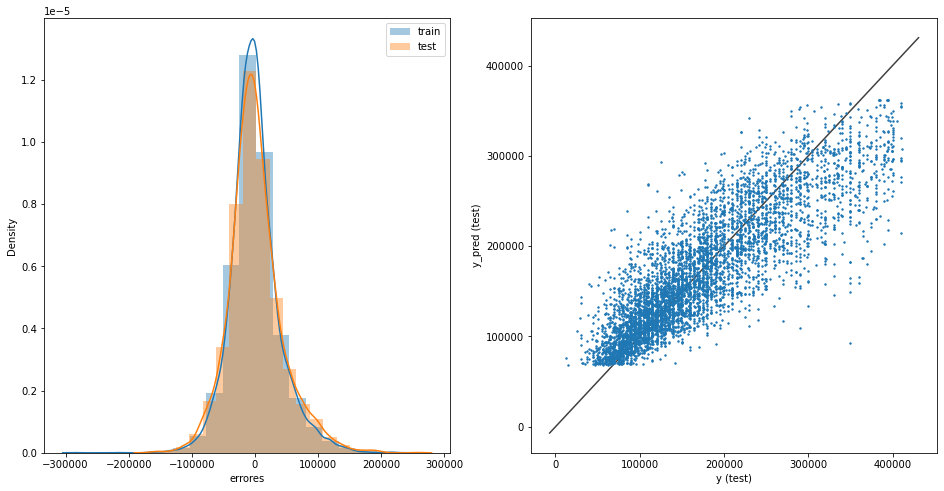

In [80]:
plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
sns.distplot(y_train - y_train_pred_lgbm, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred_lgbm, bins = 20, label = 'test')
plt.xlabel('errores')
plt.legend()


ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred_lgbm, s =2)

lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
]

ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')

# Resultados finales TP2:
Los algoritmos que mejor RMSE dieron fueron (en este orden):

In [81]:
resultados

,Model,MAE,MSE,RMSE,R2,CV
0,TP1 Knn,0.00,0.00,152699.00,0.00,0.00
1,Knn,33518,2.15538e+09,46426.1,0.684184,0.716627
2,RandomForest,26974.8,1.56906e+09,39611.3,0.770095,0.774809
3,XGBoost-Tree,28136.3,1.84351e+09,42936.1,0.729881,0.766614
4,XGBoost-Linear,35072.6,2.22665e+09,47187.4,0.673741,0.766614
5,MS LightGBM,31710.5,1.8749e+09,43300.1,0.725281,0.775686


Veamos un poco que significa cada métrica:
MAE, el error se calcula como un promedio de diferencias absolutas entre los valores objetivo y las predicciones.<br>
MSE mide el error cuadrado promedio de nuestras predicciones.Cuanto más cercano a 0, en teoría, mejor.<br>
El RMSE es la RAIZ del MSE. Sirve para alinear la métrica a mi variable de respuesta.<br>
R² es la proporción entre lo bueno que es nuestro modelo y un modelo medio, donde valores cercanos a 0 indicarán que nuestro modelo no es ni bueno ni malo. Cuanto más cerca de 1 mejor.<br>
Cross_val_score es similar a R² pero mejora la precisión. 

Wall time: 178 ms


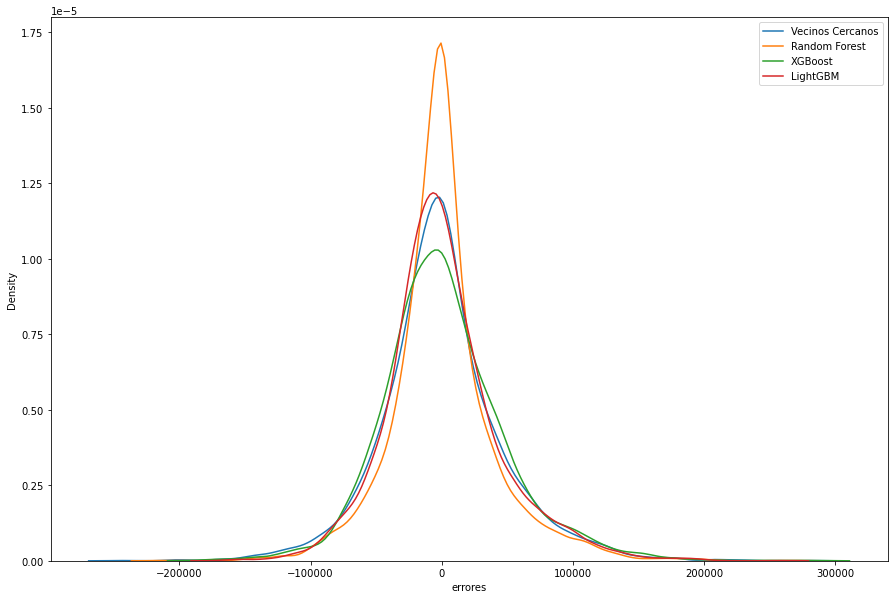

In [82]:
%%time
plt.figure(figsize = (15,10))
sns.distplot((y_test) -(y_test_pred_knn), bins = 10, label = 'Vecinos Cercanos',hist=False)
sns.distplot((y_test) -(y_test_pred_RFR), bins = 10, label = 'Random Forest',hist=False)
sns.distplot((y_test) -(y_test_pred_XGB), bins = 10, label = 'XGBoost',hist=False)
sns.distplot((y_test) -(y_test_pred_lgbm), bins = 10, label = 'LightGBM',hist=False)
plt.xlabel('errores')
plt.legend()

### Guardando nuestros modelos entrenados:
Vamos a guardar nuestros modelos entrenados para utilizarlos en otra oportunidad o quizás hacer una "herramienta web de valuación de propiedades" levantando nuestros modelos y pasandole nuevas características

In [83]:
import pickle
#Guardamos el modelo de mejor performance en un archivo local
#with open("TP2_knn.pkl", 'wb') as file: pickle.dump(clf_knn, file)
with open("TP2_RFR.pkl", 'wb') as file: pickle.dump(RFR, file)
#with open("TP2_XGB.pkl", 'wb') as file: pickle.dump(xgbregressor, file)
#with open("TP2_LGBM.pkl", 'wb') as file: pickle.dump(gbm, file)

# Para levantar el modelo se debera utilizar :
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Veamos la correlación de Pearson entre las variables que entraron al modelo: 
Para visualizarlo mejor, al ser tantas variables, guardaremos los resultados en un JPG para poder hacer zoom.

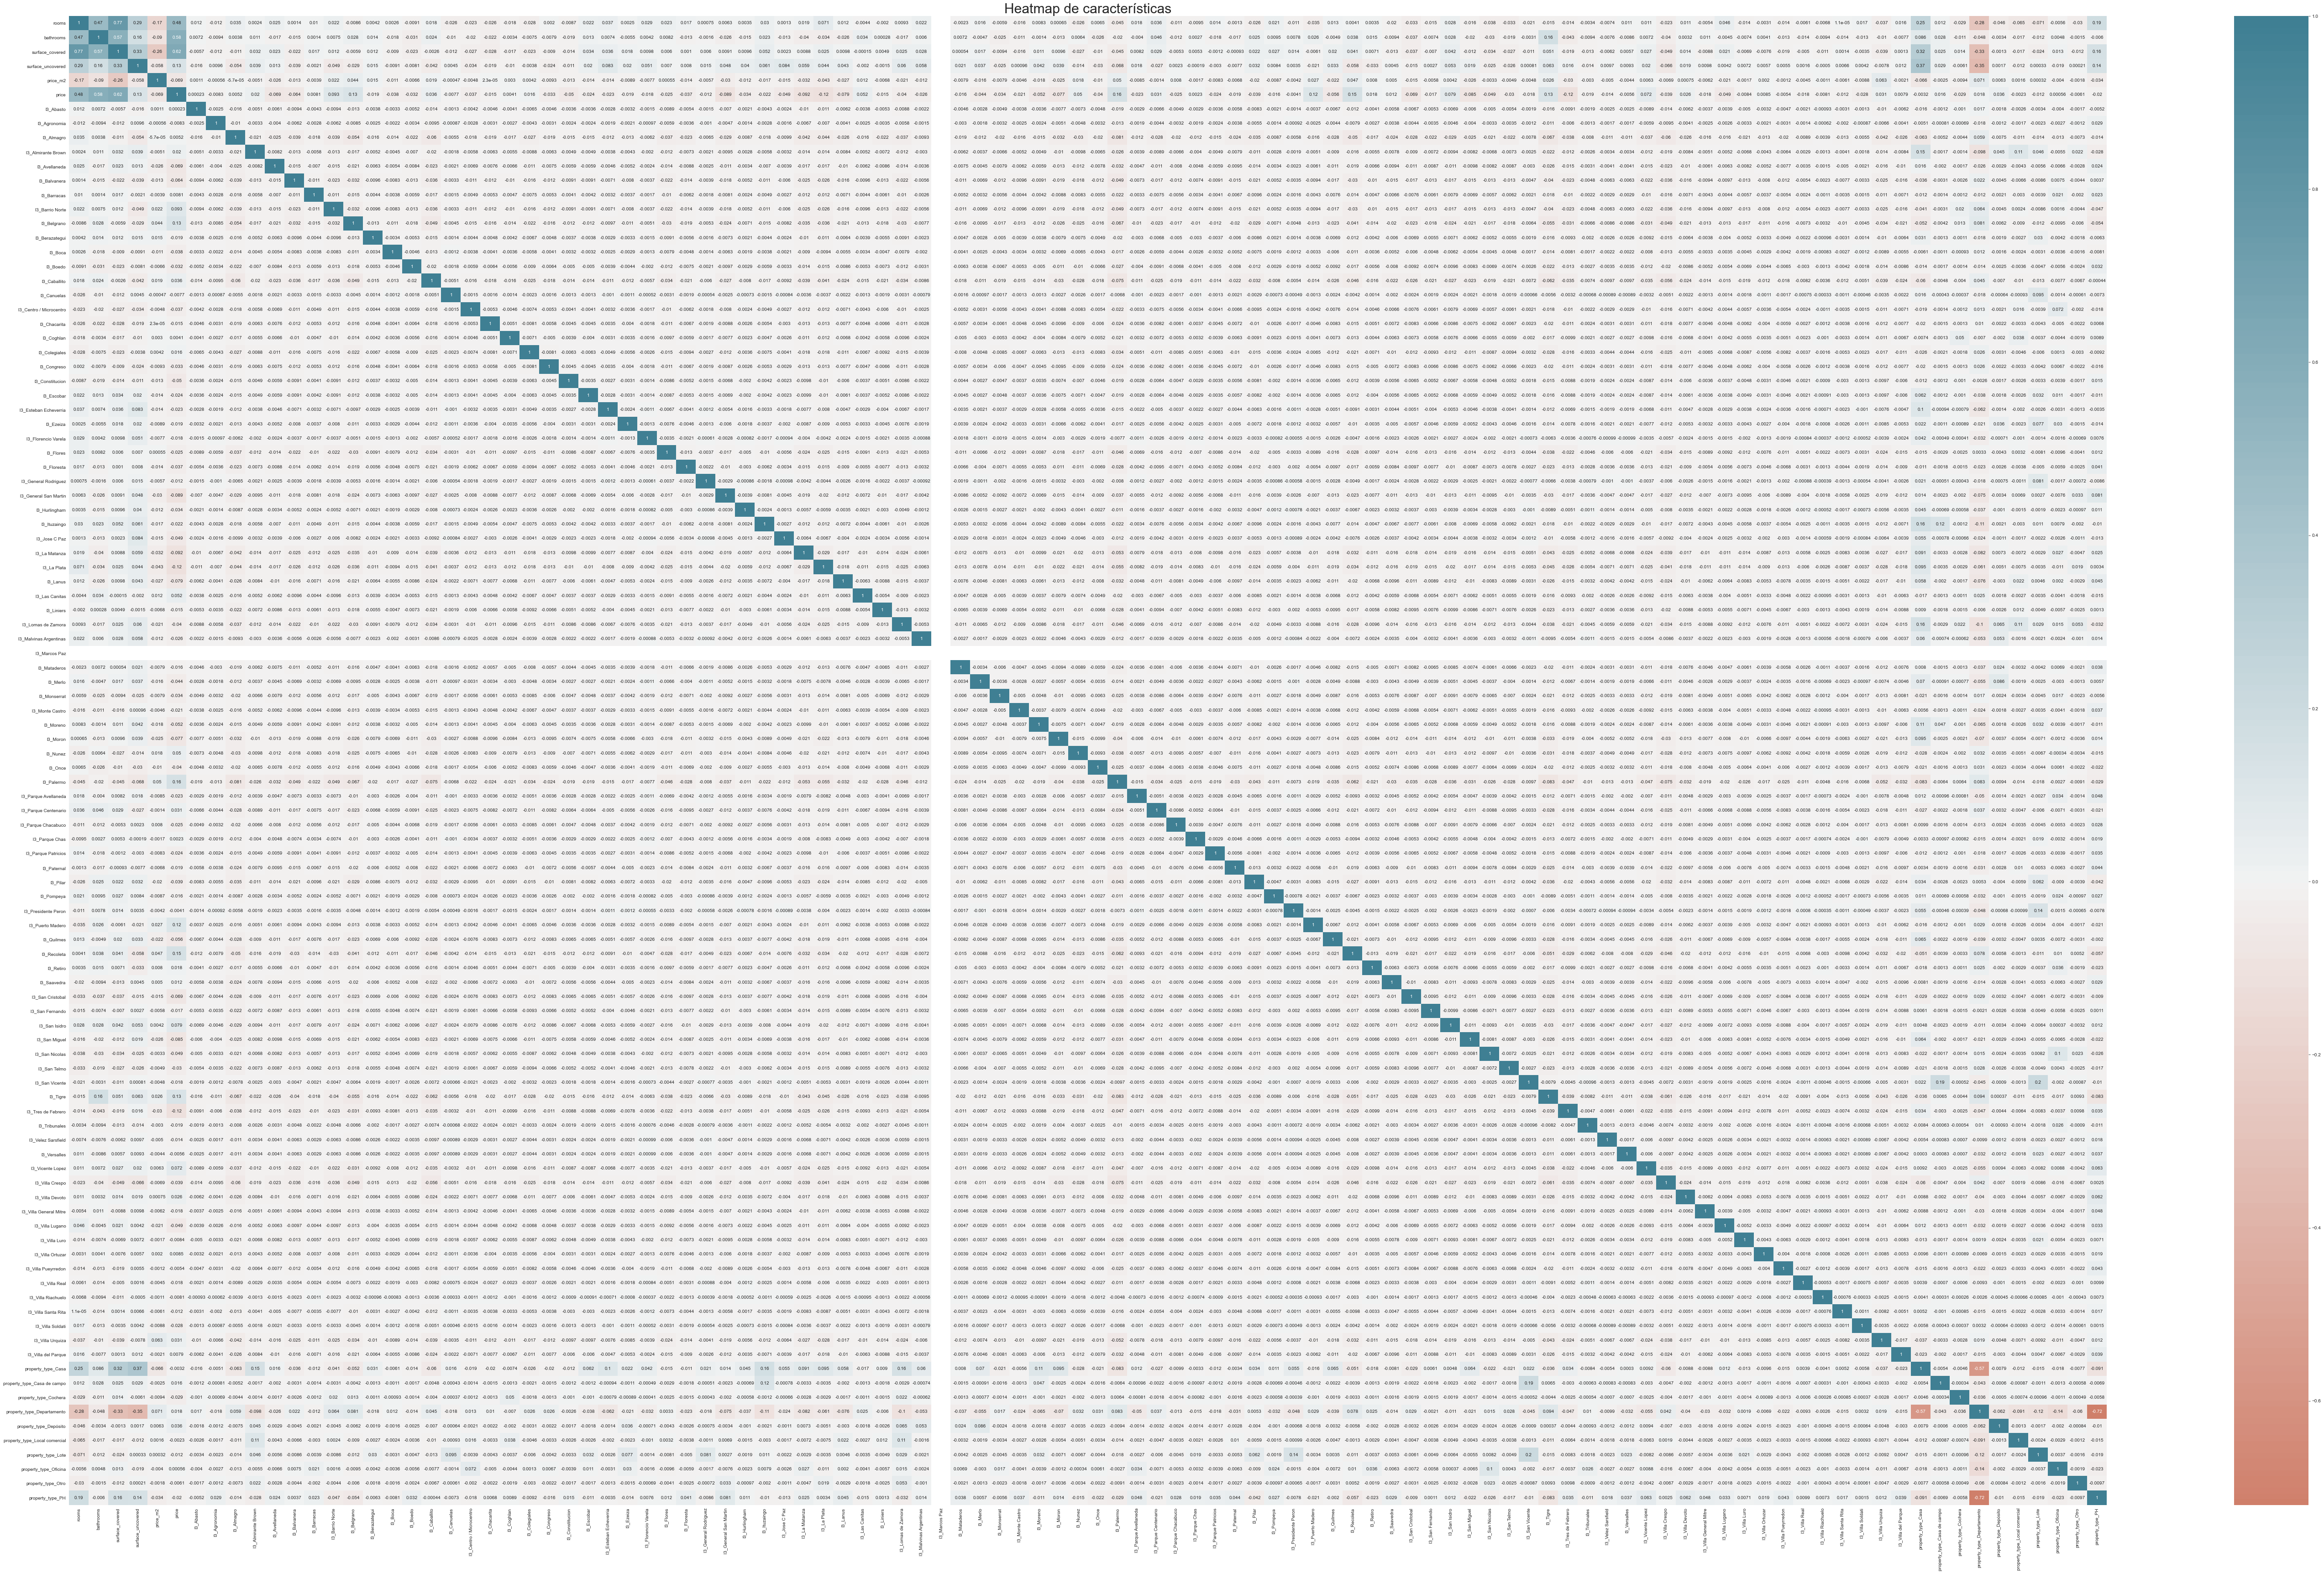

In [84]:
## Plot fig sizing. 
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (100,60))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            #mask = mask, 
            annot=True, 
            center = 0, 
           );
## Guardamos el archivo en un JPG para analizar mejor las correlaciones entre los features. 
plt.title("Heatmap de características", fontsize = 30);

plt.savefig("Correlaciones_Pearson.jpg")

# Conclusión Parte B - Modelos avanzados
La gran conclusión de esta parte es que fue clave todo el proceso de ingeniería de características. En este sentido en la optimización de hiperparámetros utilicé la metodología de malla fina y malla gruesa para ir ajustando de manera crítica y no probar rangos completos para cada hiperparámetro ya que el costo computacional de haber obtenido estos resultados sin ese criterio hubieran sido varios días de procesamiento en algunos modelos.<BR>
Los modelos avanzados utilizados fueron tres: Random Forest (), XGBoost y LightGBM.

Antes de sacar conclusiones, veamos los resultados obtenidos de manera unificada, aunque primero eliminaremos los datos del TP1:

In [85]:
resultados = resultados.drop([0])
resultados

,Model,MAE,MSE,RMSE,R2,CV
1,Knn,33518,2.15538e+09,46426.1,0.684184,0.716627
2,RandomForest,26974.8,1.56906e+09,39611.3,0.770095,0.774809
3,XGBoost-Tree,28136.3,1.84351e+09,42936.1,0.729881,0.766614
4,XGBoost-Linear,35072.6,2.22665e+09,47187.4,0.673741,0.766614
5,MS LightGBM,31710.5,1.8749e+09,43300.1,0.725281,0.775686


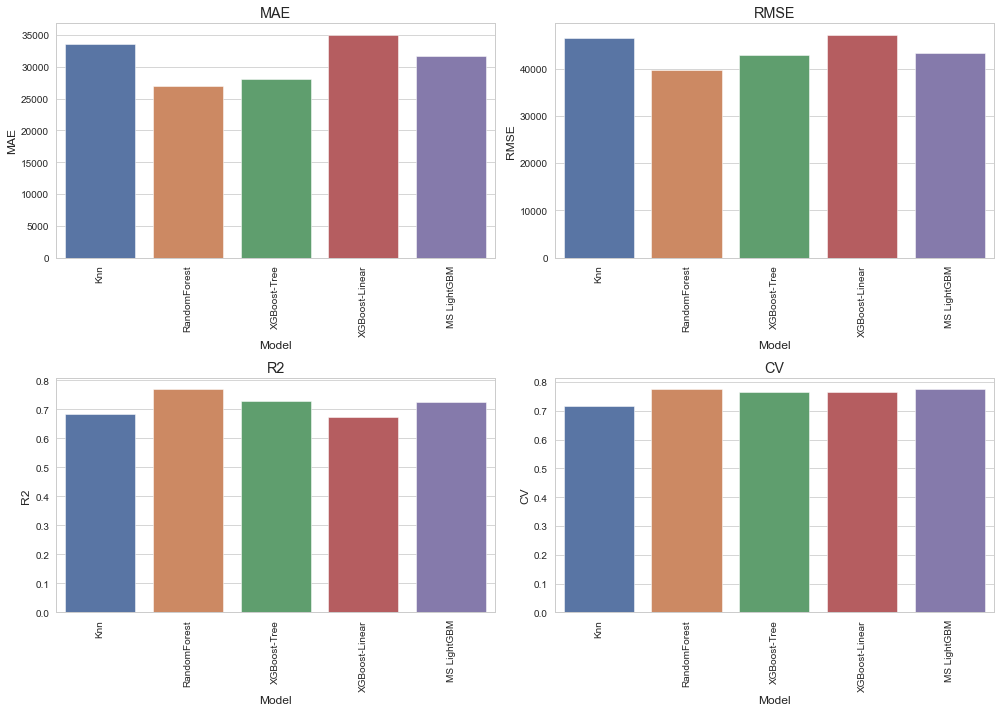

In [86]:
from matplotlib import gridspec
fig = plt.figure(figsize=(14,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1])
plt.subplot(gs[0])
plt.title('MAE')
plt.xticks(rotation = 90)
ax = sns.barplot(x = 'Model', y = 'MAE', data= resultados, palette = 'deep')
plt.subplot(gs[1])
plt.title('RMSE')
plt.xticks(rotation = 90)
ax2 = sns.barplot(x = 'Model', y = 'RMSE', data= resultados, palette = 'deep')
plt.subplot(gs[2])
plt.title('R2')
plt.xticks(rotation = 90)
ax2 = sns.barplot(x = 'Model', y = 'R2', data= resultados, palette = 'deep')
plt.subplot(gs[3])
plt.title('CV')
plt.xticks(rotation = 90)
ax2 = sns.barplot(x = 'Model', y = 'CV', data= resultados, palette = 'deep')
plt.tight_layout()
plt.show()

# Conclusión Parte B:
Me sorprendió gratamente los resultados obtenidos con todos los modelos respecto del TP1.<BR>
Es evidente que estabamos intentando tapar el sol con la mano. Está a la vista que una buena ingeniería de características y el análisis crítico son más importantes que el algoritmo que utilicemos para nuestro modelo. <BR><BR>
Hablando ya propiamente de los algoritmos utilizados, todos tuvieron un muy buen desempeño con valores de MAE y RMSE sorprendentes. En este sentido, al poner los resultados en contexto con una mirada holística junto a valores de R2 y Crossval sólidos, considero que el modelo obtenido (todos pero aún más Random Forest)  son confiables y le agregaría valor al trabajo diario de los tasadores.

# PARTE C - Interpretación de modelos
Para interpretar el modelo veamos que importancia tuvieron las características ingresadas en el modelo que mejor resultado tuvo (Random Forest)<BR>
Para esto, utilizaremos la función "feature_importances_" que nos traerá el coeficiente asignado a cada característica. Para simplificar el análisis lo limitaremos al top 10 de características:

In [87]:
importante=pd.DataFrame(data=pd.DataFrame(RFR.feature_importances_).values,index=X.columns,columns=['importancia'])
importante.sort_values('importancia',ascending=False,inplace=True)
importante['features']=importante.index
importante=importante.head(10)
importante.head(10)

,importancia,features
surface_covered,0.273605,surface_covered
bathrooms,0.148909,bathrooms
price_m2,0.134198,price_m2
rooms,0.097617,rooms
surface_uncovered,0.094955,surface_uncovered
l3_Palermo,0.029015,l3_Palermo
l3_Recoleta,0.019177,l3_Recoleta
l3_Belgrano,0.015203,l3_Belgrano
property_type_Departamento,0.013756,property_type_Departamento
l3_PuertoMadero,0.011909,l3_PuertoMadero


In [88]:
importante=importante.head(4)
print (importante)

                 importancia         features
surface_covered     0.273605  surface_covered
bathrooms           0.148909        bathrooms
price_m2            0.134198         price_m2
rooms               0.097617            rooms


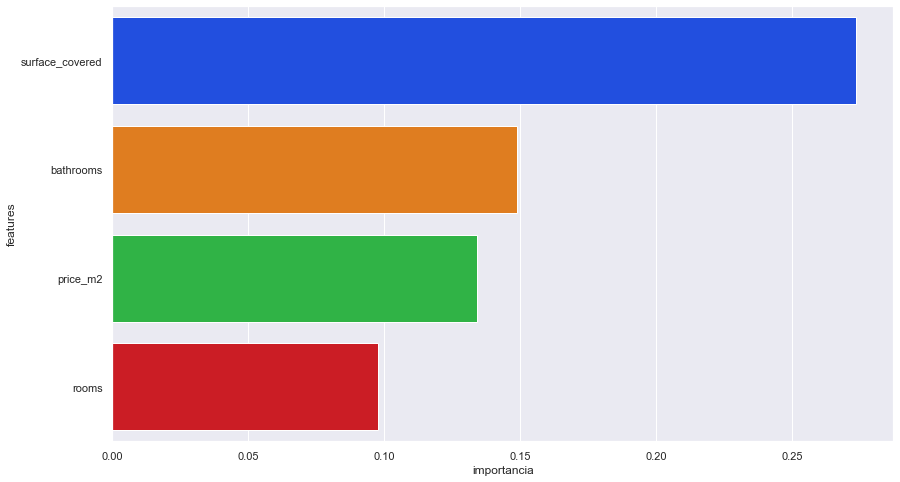

In [89]:
#grafico_resultado = sns.countplot(x="Importancia",data=importante)
sns.set(rc={'figure.figsize':(14,8)})
sns_l3_cant = sns.barplot(x='importancia', y='features', data = importante,palette = 'bright' )

El gráfico no aporta mucho ya que El peso que adquirieron las características para Random Forest (el modelo de mejor desempeño) coincide bastante con lo que esperaba.<BR>
Los dos features creados (price_m2 y surface_uncovered) estan en el top 4 de feature_importance lo cual me satisface porque son datos que no traía el dataset y ayudaron al modelo. También están los baños y mas abajo aparecen algunos tipos de propiedad y algunos barrios, (los más costosos de Buenos Aires).<BR>
En síntesis, creo que es asemejable a lo que un tasador tendría en cuenta para valuar una propiedad.<BR>

### Que mejoré ? 
Al modelo una vez terminado, y en base al análisis del punto C le mejoré dos cosas:<BR>
1. De las 3 características que más influyeron en el modelo, dos eran surface_total y surface_covered con una correlación de 0.84 lo cual probablemente hubiera sesgado al modelo en algunos casos. Para corregir esto decidí crear una nueva caraterística que represente la superficie descubierta (surface_uncovered) que es producto de restarle a la superficie total, la superficie cubierta. <BR>
2. La segunda tiene que ver con la otra característica creada: el precio por m2. Indudablemente es una variable que consolida muchos aspectos, pero que lamentablemente tiene incorporada la variable de respuesta por lo que los resultados obtenidos eran un espejismo.<BR>
Para solucionar esto, se cambió la fórmula para calcular el precio del m2, definiendolo como el promedio del precio por m2 por barrio (l3) de la siguiente manera: data['price_m2'] = data.groupby('l3')['price'].transform('mean'), de esta forma agregamos valor al modelo pero apoyándonos en datos estadísticos.

### Que mejoraría a futuro ?
Me hubiera gustado mejorar el modelo con dos cosas:<BR>
1) La primera tiene que ver con identificar una fecha de publicación y una fecha de venta, para sacar cuanto tiempo estuvo publicada la propiedad. De esta manera podríamos identificar zonas "tendencia" y proponerle al tasador arrancar con una valuación un poco más alta.<BR>
Por otra parte en polo apuesto, se podrían identificar aquellas zonas que son difíciles de vender y sugerirle un precio de venta menor para no tener la propiedad publicada por años.<BR><BR>
2) Lo segundo que me hubiera gustado realizar es, utilizando el modelo que mejor dió (Random Forest), una aplicación web para valuar propiedades la cual podría estar en la intranet de la inmobiliaria para rápida referencia de los tasadores.<BR>

Esto ha sido todo amigos, espero haber cumplido con los objetivos planteados. Hasta la próxima.

![ChessUrl](https://i.pinimg.com/originals/3e/51/98/3e51980fa514498df06cdcc64409074b.gif "Fin")

En memoria de Diego Armando Maradona:<BR><BR>
![ChessUrl](https://media.airedesantafe.com.ar/adjuntos/268/imagenes/002/269/0002269253.gif "D10S")<BR>
<BR>
Lo leí. Fui a twitter y no quería creerlo. El sensasionalismo seguro estaba equivocado. Ibas a gambetear al destino una vez más, pero no.
Es increíble como el tiempo va liberando recuerdos que no sabías que tenías. De tu infancia, tu familia. Ojalá desde arriba puedas unirnos una vez más como pueblo. Solo vos podes hacer eso Diego.
Lo que sentí hoy fue una mezcla de tristeza, angustia, nostalgia, alegría y admiración. 
Ahora me doy cuenta, no viniste a dirigir a Gimnasia, viniste a despedirte uno por uno de todos los clubes de tu amado fútbol argentino. 
Creo que en gran parte vos resumis el ADN de todos los Argentinos. Quien puede ser Maradona hoy ? Quien quiere cargarse en el peso de su espalda tener que hacer feliz a un país. Eso debe doler en los huesos. 
Te pido perdón por las veces que me sentí con derecho a criticarte en tu paso como técnico de la selección, cuando ya eras D10S y arriesgaste todo por ganar otra copa del mundo.
Ojalá mañana descubramos en este año surrealista que esta es una broma más del destino y que todo fue una pesadilla.
Quiero terminar con un enorme GRACIAS ! por mil cosas, pero la más importante para mi , Diego, fue hacerme amar el fútbol, ese idioma indescriptible, para el que piensa que son solo 11 tipos corriendo atrás de una pelota. El fútbol no se piensa, se siente.
Fuiste leyenda en vida y sos desde hoy un prócer para la historia de mi país, la Argentina. <BR><BR>
No se me ocurre otra forma de terminar que escuchando esta canción:<BR><BR>
[Tributo: La mano de D10S de Rodrigo en Spotify](https://open.spotify.com/track/4zYxRPe5QL8UVR76jTW4Zy)<BR>   <BR> 
    Te quiero Diego !

# TP 2
Por Mariano Parada<BR>
DS-33<BR>
[Github:](https://github.com/marianoparada/DataScience)